In [ ]:
!pip install --upgrade torch torchvision torchinfo

CODE BLOCK: 1

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary  #

CODE BLOCK: 2

In [3]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu")  #

CUDA Available? True


CODE BLOCK: 3

In [4]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  #
])

CODE BLOCK: 4

In [10]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)  #

CODE BLOCK: 5

In [11]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'num_workers': 2, 'pin_memory': True}  #

test_loader = torch.utils.data.DataLoader(test_data, shuffle=False, **kwargs)  #
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, **kwargs)

CODE BLOCK: 6

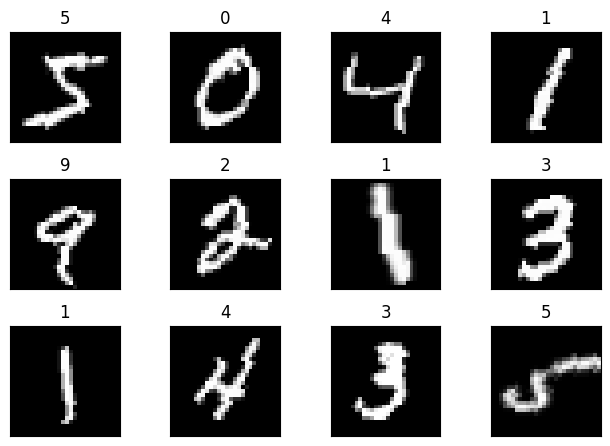

In [15]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3, 4, i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [19]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x))
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        x = x.view(-1, 4096)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [20]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28),
        col_names=["input_size", "output_size", "num_params", "params_percent"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %
Net                                      [1, 28, 28]               [1, 10]                   --                             --
├─Conv2d: 1-1                            [1, 28, 28]               [32, 26, 26]              320                         0.05%
├─Conv2d: 1-2                            [32, 26, 26]              [64, 24, 24]              18,496                      3.12%
├─Conv2d: 1-3                            [64, 12, 12]              [128, 10, 10]             73,856                     12.45%
├─Conv2d: 1-4                            [128, 10, 10]             [256, 8, 8]               295,168                    49.76%
├─Linear: 1-5                            [1, 4096]                 [1, 50]                   204,850                    34.53%
├─Linear: 1-6                            [1, 50]                   [1, 10]                   510               

CODE BLOCK: 8

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

CODE BLOCK: 8

In [ ]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

CODE BLOCK: 9

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)  #
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)  #
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=0.1074 Batch_id=117 Accuracy=79.75: 100%|██████████| 118/118 [00:23<00:00,  5.10it/s]


Test set: Average loss: 0.0608, Accuracy: 9828/10000 (98.28%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 2


Train: Loss=0.0720 Batch_id=117 Accuracy=97.50: 100%|██████████| 118/118 [00:23<00:00,  4.98it/s]


Test set: Average loss: 0.0377, Accuracy: 9889/10000 (98.89%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 3


Train: Loss=0.0219 Batch_id=117 Accuracy=98.37: 100%|██████████| 118/118 [00:23<00:00,  5.09it/s]


Test set: Average loss: 0.0279, Accuracy: 9904/10000 (99.04%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 4


Train: Loss=0.0463 Batch_id=117 Accuracy=98.65: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


Test set: Average loss: 0.0295, Accuracy: 9905/10000 (99.05%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 5


Train: Loss=0.0008 Batch_id=117 Accuracy=98.75: 100%|██████████| 118/118 [00:22<00:00,  5.15it/s]


Test set: Average loss: 0.0253, Accuracy: 9920/10000 (99.20%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 6


Train: Loss=0.0505 Batch_id=117 Accuracy=98.97: 100%|██████████| 118/118 [00:22<00:00,  5.17it/s]


Test set: Average loss: 0.0225, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 7


Train: Loss=0.0072 Batch_id=117 Accuracy=99.04: 100%|██████████| 118/118 [00:22<00:00,  5.20it/s]


Test set: Average loss: 0.0235, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 8


Train: Loss=0.0107 Batch_id=117 Accuracy=99.09: 100%|██████████| 118/118 [00:22<00:00,  5.21it/s]


Test set: Average loss: 0.0221, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 9


Train: Loss=0.0153 Batch_id=117 Accuracy=99.17: 100%|██████████| 118/118 [00:22<00:00,  5.19it/s]


Test set: Average loss: 0.0216, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 10


Train: Loss=0.0024 Batch_id=117 Accuracy=99.15: 100%|██████████| 118/118 [00:22<00:00,  5.21it/s]


Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 11


Train: Loss=0.0090 Batch_id=117 Accuracy=99.31: 100%|██████████| 118/118 [00:22<00:00,  5.20it/s]


Test set: Average loss: 0.0198, Accuracy: 9937/10000 (99.37%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 12


Train: Loss=0.0498 Batch_id=117 Accuracy=99.38: 100%|██████████| 118/118 [00:23<00:00,  5.12it/s]


Test set: Average loss: 0.0206, Accuracy: 9931/10000 (99.31%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 13


Train: Loss=0.0215 Batch_id=117 Accuracy=99.30: 100%|██████████| 118/118 [00:23<00:00,  5.11it/s]


Test set: Average loss: 0.0215, Accuracy: 9935/10000 (99.35%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 14


Train: Loss=0.0244 Batch_id=117 Accuracy=99.36: 100%|██████████| 118/118 [00:23<00:00,  5.10it/s]


Text(0.5, 1.0, 'Test Accuracy')

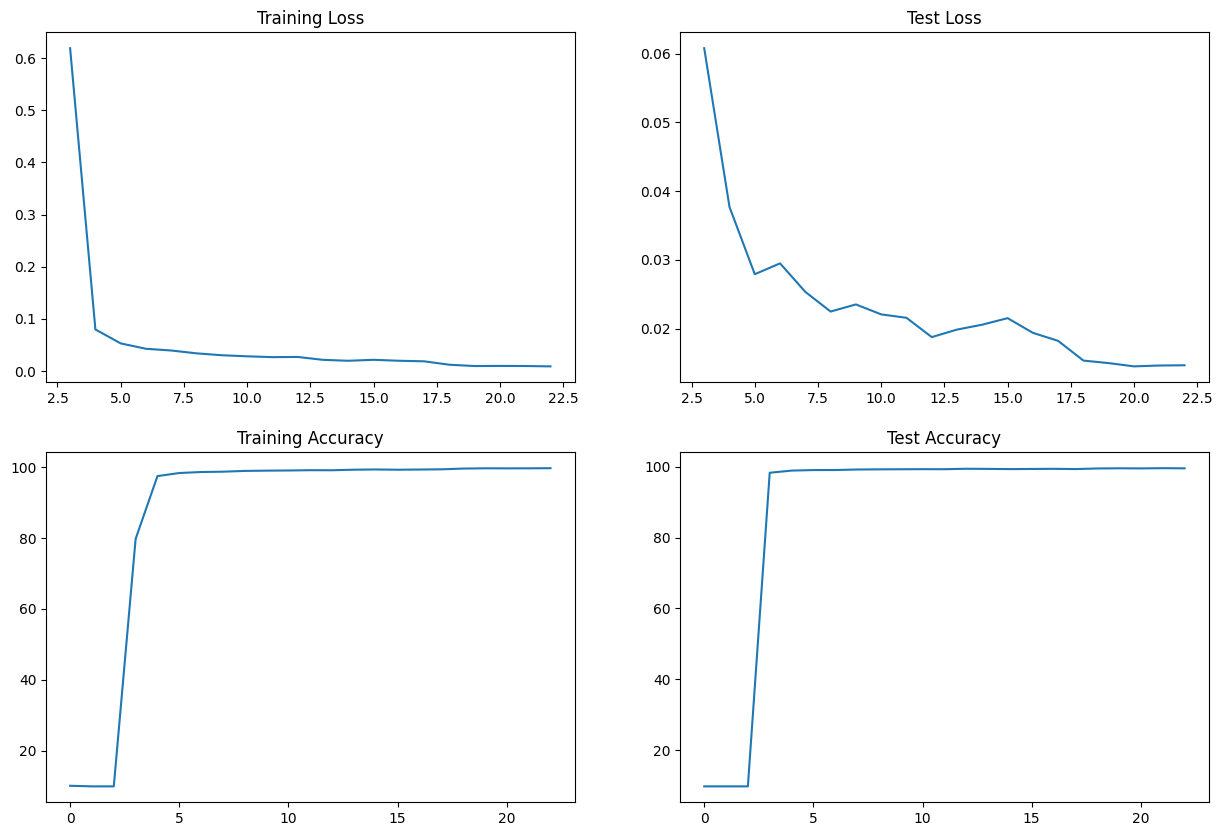

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
test_acc

[9.8,
 9.8,
 9.8,
 98.28,
 98.89,
 99.04,
 99.05,
 99.2,
 99.24,
 99.27,
 99.29,
 99.28,
 99.41,
 99.37,
 99.31,
 99.35,
 99.39,
 99.32,
 99.49,
 99.54,
 99.51,
 99.57,
 99.53]

In [ ]:
def GetInCorrectPreds(pPrediction, pLabels):
  pPrediction = pPrediction.argmax(dim=1)
  indices = pPrediction.ne(pLabels).nonzero().reshape(-1).tolist()
  return indices, pPrediction[indices].tolist(), pLabels[indices].tolist()

In [ ]:
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

def test_show_incorrect(model, device, test_loader):
    model.eval()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)

            ind, pred, truth = GetInCorrectPreds(output, target)
            test_incorrect_pred['images'] += data[ind]
            test_incorrect_pred['ground_truths'] += truth
            test_incorrect_pred['predicted_vals'] += pred

In [ ]:
test_show_incorrect(model, device, test_loader)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc705525360>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc705525360>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():
AssertionError: can only test a child process

  File "/usr/lib/

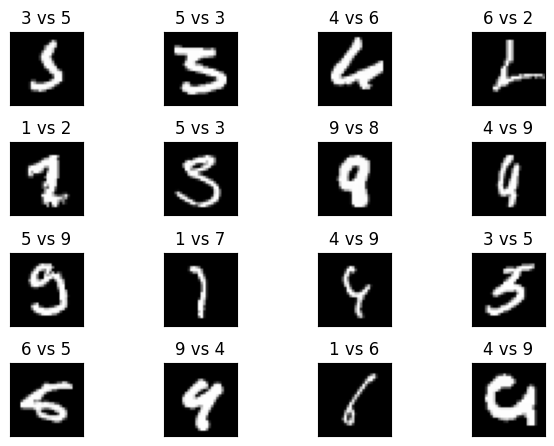

In [ ]:
fig = plt.figure()

for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.tight_layout()
  plt.imshow(test_incorrect_pred['images'][i].cpu().squeeze(0), cmap='gray')
  plt.title(repr(test_incorrect_pred['predicted_vals'][i]) + ' vs ' + repr(test_incorrect_pred['ground_truths'][i]))
  plt.xticks([])
  plt.yticks([])